# **EE 488 AI Convergence Capstone Design : Anomaly Detection**
## **Unsupervised Detection of Anomalous Sounds for Machine Condition Monitoring (DCASE 2020 baseline)**

**Description**

Anomalous Sound Detection (ASD) is the task to identify whether the sound emmited from a target machine is normal or anomalous.
The main challenge of this task is to detect unknown anomalous sounds under the condition that only normal sound samples have been provided as training data. 💻

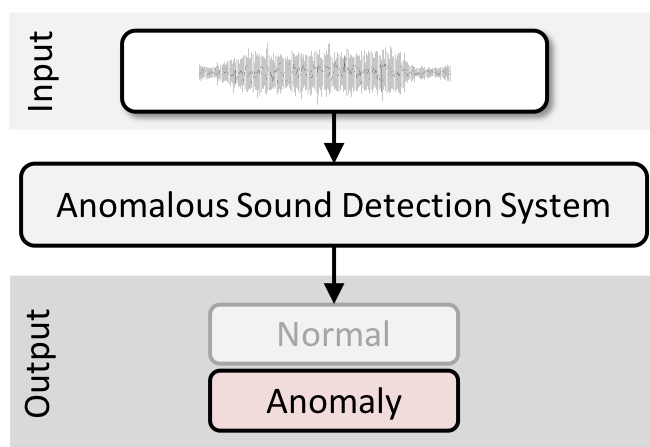


**Dataset**

The data used for this task comprises part of **ToyADMOS** and the **MIMII dataset** consisting of the normal/anomalous operating sounds of six machine types. Each recording is a single-channel 10-sec length audio that includes both a target machine's operating sound and environmental noise. There are six machine types: `ToyCar`, `ToyConveyor`, `Fan`, `Pump`, `Slider`, and `Valve`, but in this example, we only use `valve` dataset.

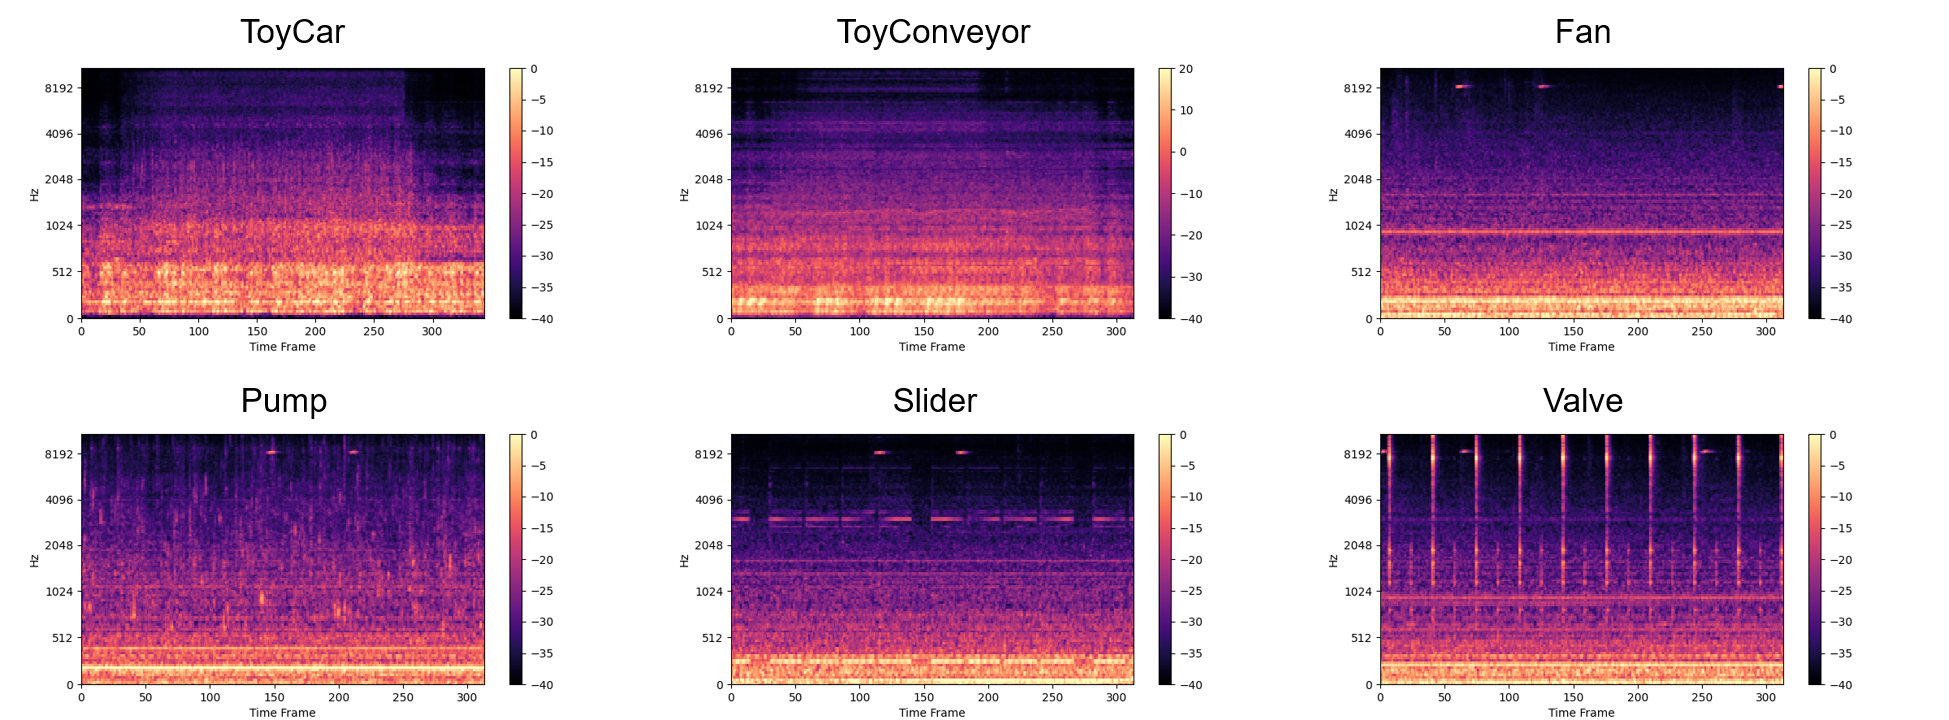

# 1. Import Packages

New library imported for this project:


*   `librosa`: a python package for music and audio analysis (https://librosa.org/doc/latest/index.html)
  - We use to get spectrograms from sound data

In [ ]:
# file system operations
import os
import sys
import glob

import numpy as np
import librosa # loading audio files and extracting features(Mel spectrogram)
import torch
from torch import nn
from torch.utils.data import DataLoader
from sklearn import metrics # evaluation metrics

# visualization & utilities
from tqdm import tqdm # Progress Bar
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd


!pip install torchinfo
from torchinfo import summary # model summary

In [ ]:
# random seed
import random

seed = 2025 # do not change
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # if using multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
your_working_dir = '/content/drive/MyDrive/25spring_anomaly' # your working directory - change this!

if not os.path.exists(your_working_dir):
    os.makedirs(your_working_dir)

os.chdir(your_working_dir) # your working directory - change this!
print(os.getcwd())

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu' # Use the GPU assigned to you
print(f'Using {device} device')

# 2. Hyperparameters

Set dataset folder path and hyperparameters.

You need to upload the dataset to Google Drive in advance.


- Dataset hierarchy (in example)  
It will depend on the directory structure of your Google Drive.

    <pre>
    your working directory  
        |_ dataset directory   
            |_fan  
                |_train
                    |normal_id_00_00000000.wav
                    |normal_id_00_00000001.wav
                    |_...
                |_test
                    |_anomaly_id_00_00000000.wav
                    |_anomaly_id_00_00000001.wav
                    |_...
            |_pump  
            |_slider
            |_ToyCar
            |_ToyConveyor
            |_valve



In [ ]:
# Dataset path setting
# machine_name : fan, pump, slider, ToyCar, ToyConveyor, valve
# You need to upload the dataset to Google Drive in advance.

dataset_dir = "./dev_data" # dataset directory in your drive - change this!
machine_name = 'fan' # machine

train_dir = os.path.join(dataset_dir, machine_name, "train")        # train dataset dir
test_dir = os.path.join(dataset_dir, machine_name, "test")              # test dataset dir
model_dir = os.path.join(your_working_dir, "model", machine_name)      # directory for saving model
os.makedirs(model_dir, exist_ok=True)

# Parameters for mel-spectrogram
n_fft = 2048                          # window size for stft
hop_length = 512                      # number of samples for window moving
n_mels = 128                          # number of frequency bin
power = 2                             # spectrogram power
frames = 5                            # number of time frames for model's input

# Training parameters
EPOCHS = 3                           # training epochs, you need to increase
BATCH = 1024                          # mini-batch size

# 3. Function Definition

For the convenience of the code, we define some functions below here.

- `file_load` : reads one 10-sec sound file and returns 1D array `y` and sampling rate `sr`

- `file_list_generator` : returns file_name list in `target_dir`

- `file_to_vector_array` : convert one file to vector array for use as input to the model

- `list_to_vector_array` : returns a total vector array of train datasets


In [ ]:
def file_load(wav_name):
  try:
    return librosa.load(wav_name, sr=None, mono=False)
  except:
    print('file_broken or not exists!! : {}'.format(wav_name))


def file_list_generator(target_dir):
  training_list_path = os.path.abspath('{dir}/*.wav'.format(dir=target_dir))
  files = sorted(glob.glob(training_list_path))
  if len(files) == 0:
    print('no_wav_file!!')
  return files


def file_to_vector_array(file_name, n_mels, frames, n_fft, hop_length, power):
  dims = n_mels * frames

  y, sr = file_load(file_name)
  mel_spectrogram = librosa.feature.melspectrogram(y=y,
                                                   sr=sr,
                                                   n_fft=n_fft,
                                                   hop_length=hop_length,
                                                   n_mels=n_mels,
                                                   power=power)

  log_mel_spectrogram = 20.0 / power * np.log10(mel_spectrogram + sys.float_info.epsilon)

  vector_array_size = len(log_mel_spectrogram[0, :]) - frames + 1

  if vector_array_size < 1:
    return np.empty((0, dims))

  vector_array = np.zeros((vector_array_size, dims))
  for t in range(frames):
    vector_array[:, n_mels * t: n_mels * (t + 1)] = log_mel_spectrogram[:, t: t + vector_array_size].T

  return vector_array


def list_to_vector_array(file_list, n_mels, frames, n_fft, hop_length, power):
  dims = n_mels * frames

  for idx in tqdm(range(len(file_list))):
    vector_array = file_to_vector_array(file_list[idx],
                                        n_mels=n_mels,
                                        frames=frames,
                                        n_fft=n_fft,
                                        hop_length=hop_length,
                                        power=power)
    if idx == 0:
      dataset = np.zeros((vector_array.shape[0] * len(file_list), dims), float)
    dataset[vector_array.shape[0] * idx: vector_array.shape[0] * (idx + 1), :] = vector_array

  return dataset

# 4. Dataset and Dataloader

Create a train dataset using the functions defined above.

In [ ]:
train_dir = os.path.abspath(train_dir)

files = file_list_generator(train_dir)
train_data = list_to_vector_array(files,
                                  n_mels=n_mels,
                                  frames=frames,
                                  n_fft=n_fft,
                                  hop_length=hop_length,
                                  power=power)

In [ ]:
train_dataset = torch.Tensor(train_data)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)

Create a test dataset using the functions defined above

In [ ]:
normal_files = sorted(glob.glob('{dir}/normal_*'.format(dir=test_dir)))
anomaly_files = sorted(glob.glob('{dir}/anomaly_*'.format(dir=test_dir)))

normal_labels = np.zeros(len(normal_files))
anomaly_labels = np.ones(len(anomaly_files))

test_files = np.concatenate((normal_files, anomaly_files), axis=0)
y_true = np.concatenate((normal_labels, anomaly_labels), axis=0)
y_pred = [0. for k in test_files]

In [ ]:
def generate_test_dataset(file_list, n_mels, frames, n_fft, hop_length, power):
  dims = n_mels * frames
  for idx in tqdm(range(len(file_list))):
    vector_array = file_to_vector_array(file_list[idx],
                                        n_mels=n_mels,
                                        frames=frames,
                                        n_fft=n_fft,
                                        hop_length=hop_length,
                                        power=power)
    if idx == 0:
      dataset = np.zeros((len(file_list), vector_array.shape[0], vector_array.shape[1]), float)
    dataset[idx] = vector_array

  return dataset

In [ ]:
test_dataset = generate_test_dataset(test_files, n_mels, frames, n_fft, hop_length, power)

# 5. Define a Baseline Model (Autoencoder)

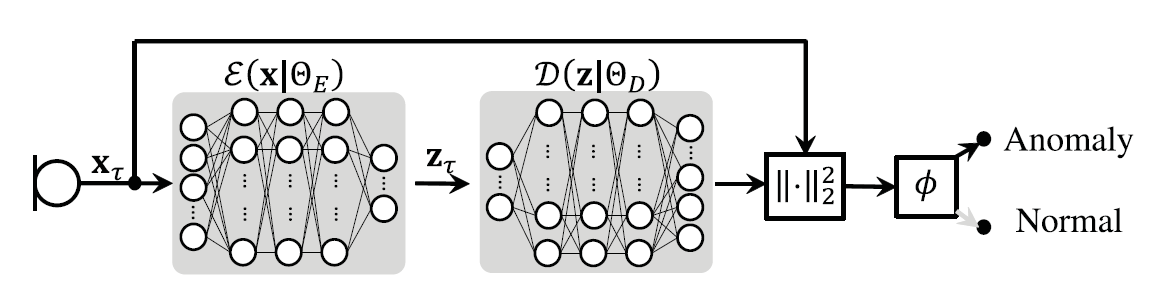


In this example, we use simple Autoencoder for anomaly detection. The input vector is compressed and reconstructed by two networks 𝓔 (which is called Encoder) and 𝓓 (which is called Decoder), respectively. Since 𝓔 and 𝓓 are trained to minimize reconstruction error of normal sounds, the reconstruction error would be small if input data 𝐱 is normal. Thus, the anomaly score is calculated as a reconstruction error, and when the error exceeds a pre-defined threshold 𝜙, the observation is identified as anomalous.



We defined a simple Autoencoder which encoder consists of 4 fully connected layers with batch normalization and relu, followed by 8-dimension latent space, and decoder consists of 4 fully connected layers.
Size of model's inputs is `n_mels * frames`. According to the initial setting, `n_mels = 128` and `frames = 5`, so the model's input size is `input_dim = 640`.

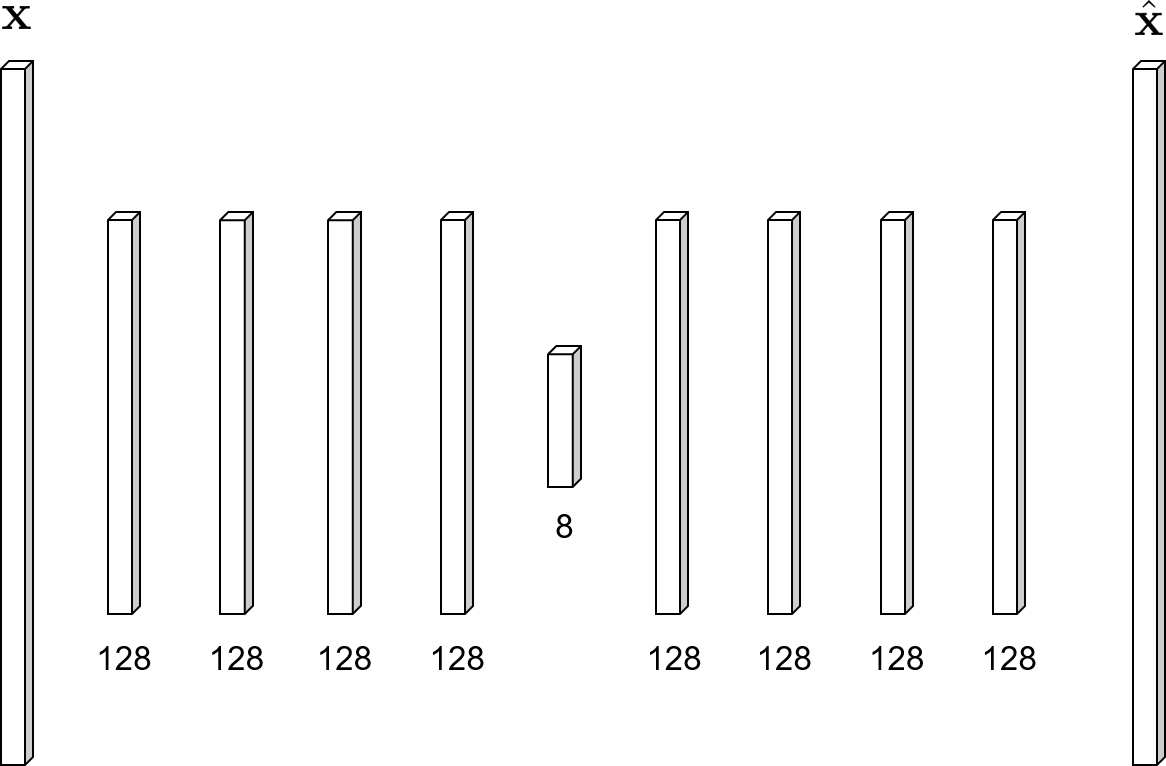

In [ ]:
class AutoEncoder(nn.Module):
  def __init__(self, input_dim):
    super(AutoEncoder, self).__init__()
    self.input_dim = input_dim
    self.encoder = nn.Sequential(
        nn.Linear(self.input_dim, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Linear(128, 8),
        nn.BatchNorm1d(8),
        nn.ReLU()
    )
    self.decoder = nn.Sequential(
        nn.Linear(8, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Linear(128, 128),
        nn.BatchNorm1d(128),
        nn.ReLU(),
        nn.Linear(128, self.input_dim)
    )

  def forward(self, x):
    latent = self.encoder(x)
    output = self.decoder(latent)
    return output

In [ ]:
model = AutoEncoder(n_mels * frames).to(device)   # Create a Autoencoder model
summary(model,input_size=(BATCH, n_mels * frames))

# 6. Define a Loss Function & Optimizers

Autoencoder learns to reconstruct the same result as the input data, so we can make Autoencoder's loss function to Mean Squared Error(MSE) of input data and reconstructed data.

In [ ]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 7. Train & Test

Define a `train` function.

In [ ]:
def train(dataloader, model, loss_fn, optimizer, device):
    size = len(dataloader.dataset)

    model.train()
    for batch, X in enumerate(dataloader):
      X = X.to(device)

      pred = model(X)               # Forward pass
      loss = loss_fn(pred, X)       # Calculate loss function

      optimizer.zero_grad()         # reset gradients
      loss.backward()               # Backward pass
      optimizer.step()              # Update model parameters

      if batch % 300 == 0:
        loss, current = loss.item(), batch * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


Define a `test` function.

In [ ]:
def get_anomaly_score(true, pred):
  error_mean = torch.mean(torch.square(true - pred), dim=1)
  anomaly_score = torch.max(error_mean)
  return anomaly_score


def test(test_dataset, model, y_true, device):
    y_pred = []

    model.eval()
    with torch.no_grad():
        for file_idx in tqdm(range(len(test_dataset)), desc='test data'):
            data = torch.tensor(test_dataset[file_idx], dtype=torch.float32).to(device)
            output = model(data)
            score = get_anomaly_score(data, output)
            y_pred.append(score.detach().cpu())

    auc = metrics.roc_auc_score(y_true, y_pred)
    fpr, tpr, _ = metrics.roc_curve(y_true, y_pred)

    return auc, fpr, tpr, y_pred

Model Training & Test

In [ ]:
best_auc = 0
best_fpr = None
best_tpr = None

for t in range(EPOCHS):
    print(f"Epoch {t + 1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, device)
    auc, fpr, tpr, y_pred = test(test_dataset, model, y_true, device)
    print(f"Epoch {t + 1} : AUC={auc:.4f}")

    if auc > best_auc:
        best_auc = auc
        best_fpr = fpr
        best_tpr = tpr
        torch.save(model.state_dict(), os.path.join(model_dir, 'best_model.pt'))
        print(f"Best model saved at epoch {t + 1} with AUC: {auc:.4f}")

# 8 Results

In [ ]:
plt.figure(figsize=(4, 4))
plt.plot(best_fpr, best_tpr)
plt.title('ROC-AUC: {}'.format(best_auc))
plt.xlabel('FPR')
plt.ylabel('TPR')

# 9. Image Comparison

You can see input data and reconstructed output of sound data.

Load best model

In [ ]:
best_model = AutoEncoder(n_mels * frames).to(device)
best_model.load_state_dict(torch.load(os.path.join(model_dir, 'best_model.pt')))
best_model.eval()

**[Normal data]**

In [ ]:
normal_data = os.path.join(test_dir, 'normal_id_00_00000000.wav')
y, sr = librosa.load(normal_data, sr=None)
ipd.Audio(y, rate=sr)

In [ ]:
normal_mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, power=power)
normal_log_mel_spec = 20.0 / power * np.log10(normal_mel_spec + sys.float_info.epsilon)

normal_vector_array = file_to_vector_array(normal_data, n_mels, frames, n_fft, hop_length, power)
output_vector_array = best_model(torch.Tensor(normal_vector_array).to(device))
vector_error = output_vector_array.detach().cpu().numpy() - normal_vector_array


plt.figure(figsize=(30, 4))
plt.subplot(1, 4, 1)
librosa.display.specshow(normal_log_mel_spec, cmap=plt.get_cmap('magma'), vmin=-40, vmax=0, x_axis='frames', y_axis='mel')
plt.title('Log Mel-Spectrogram')

plt.subplot(1, 4, 2)
librosa.display.specshow(normal_vector_array, cmap=plt.get_cmap('magma'), vmin=-40, vmax=0, y_axis='frames')
plt.title('Input Vector Array')

plt.subplot(1, 4, 3)
librosa.display.specshow(output_vector_array.detach().cpu().numpy(), cmap=plt.get_cmap('magma'), vmin=-40, vmax=0, y_axis='frames')
plt.title('Output Vector array')

plt.subplot(1, 4, 4)
librosa.display.specshow(vector_error, cmap=plt.get_cmap('RdGy'), vmin=-40, vmax=40, y_axis='frames')
plt.title('Error Map')

**[Anomaly data]**

In [ ]:
anomaly_data = os.path.join(test_dir, 'anomaly_id_00_00000000.wav')

y, sr = librosa.load(anomaly_data, sr=None)
ipd.Audio(y, rate=sr)

In [ ]:
anomaly_mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels, power=power)
anomaly_log_mel_spec = 20.0 / power * np.log10(anomaly_mel_spec + sys.float_info.epsilon)

anomaly_vector_array = file_to_vector_array(anomaly_data, n_mels, frames, n_fft, hop_length, power)
output_vector_array = best_model(torch.Tensor(anomaly_vector_array).to(device))
vector_error = output_vector_array.detach().cpu().numpy() - anomaly_vector_array


plt.figure(figsize=(30, 4))
plt.subplot(1, 4, 1)
librosa.display.specshow(anomaly_log_mel_spec, cmap=plt.get_cmap('magma'), vmin=-40, vmax=0, x_axis='frames', y_axis='mel')
plt.title('Log Mel-Spectrogram')

plt.subplot(1, 4, 2)
librosa.display.specshow(anomaly_vector_array, cmap=plt.get_cmap('magma'), vmin=-40, vmax=0, y_axis='frames')
plt.title('Input Vector Array')

plt.subplot(1, 4, 3)
librosa.display.specshow(output_vector_array.detach().cpu().numpy(), cmap=plt.get_cmap('magma'), vmin=-40, vmax=0, y_axis='frames')
plt.title('Output Vector array')

plt.subplot(1, 4, 4)
librosa.display.specshow(vector_error, cmap=plt.get_cmap('RdGy'), vmin=-40, vmax=40, y_axis='frames')
plt.title('Error Map')